<a href="https://colab.research.google.com/github/ChamudiKashmila/Assignment/blob/master/clustering_MuB_sigmaC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports 
from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer

%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from IPython.display import Image
from sklearn.manifold import TSNE

# model 
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Reshape, MaxPooling1D, GlobalAveragePooling1D, Dropout, MaxPool1D, BatchNormalization, Flatten
from sklearn.model_selection import train_test_split
from sklearn import metrics

# tf
import tensorflow as tf

# count 
from collections import Counter
#######################################################################
from keras.callbacks import ModelCheckpoint
#######################################################################

In [ ]:
# mount drive to get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/clustering2/clustering")

In [ ]:
ls

Aligned_SigmaC_clustering.ipynb  muB_4_clustering.ipynb
aligned_sigmaC.csv               muB.csv
clustering.ipynb                 mymodel.h5
C_MuB_cnn.ipynb                  sigmaC.csv
DNAdf.csv                        sigma-C-mafftAlign.fasta


In [ ]:
df = pd.read_csv("muB.csv")
print(df.type.value_counts())

1    166
2     48
3     40
0      4
Name: type, dtype: int64


In [ ]:
#df.type.value_counts().plot(kind= "bar")

In [ ]:
# read line by line from file and store seq /  lables in lists 
# read line by line from file and store seq /  lables in lists 
def readData(filename):
  seqs_all = []
  labels_all = []
  is_head = True
  f = open(filename)

  print("read line by line from file and store seq /  lables in lists ")  
  for line in f:
    if not is_head:
        data = line.split(",")
        seqs_all.append(data[1])
        labels_all.append(int(data[2].rstrip())) 
    #print(data[1])
    #print(data[2].rstrip())    
    if is_head:
      is_head = False
  f.close()

  return seqs_all, labels_all 


#MuB dataset with 4 clusters

In [ ]:
file_name = "muB.csv"
seqs_all, labels_all = readData(file_name)
print(" seqs_all = "+str(len(seqs_all)), " labels_all = "+ str(len(labels_all)))

read line by line from file and store seq /  lables in lists 
 seqs_all = 258  labels_all = 258


In [ ]:
# prep data and lebels 

def label_to_count(labels):
    '''
    Given a list of labels, returns a dictionary that maps each class label to how many
    instances of that label were present in the list.
    '''
    label_to_count_dict = {}
    for label in labels:
        if label not in label_to_count_dict:
            label_to_count_dict[label] = 0
        label_to_count_dict[label] += 1
    return label_to_count_dict

def prepare_data(seqs):
    '''
    Given a list of sequences, will turn into a tokenized vector.
    
    ARGS:
        seqs: a list of strings where every string is a sequence
    RETURNS:
        tokenized_seqs (list(list(int))): list of list of tokens
        voc2ind (dict) a dictionary where keys are letters, values are the corresponding token
    '''
    max_len = 0
    
    # build up a voc2ind (letters:token)
    # based on ATGC and include padding and unknown tokens
    voc2ind = {voc:ind for ind,voc in enumerate(['<pad>', '<unk>', 'A', 'T', 'C', 'G'])}
    
    i = len(voc2ind)
    
    # tokenize the sequences
    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            # make sure the sequence is upper case, a == A
            seq = seq.upper()
            # if we haven't seen this letter before, add to the corupus
            if not e in voc2ind:
                voc2ind[e] = i
                i += 1
            tokenized_seq.append(voc2ind[e])
        tokenized_seqs.append(tokenized_seq)
        
    return tokenized_seqs, voc2ind
        
res = prepare_data(['ATCG', 'TAGA', 'APO'])
print(res)
assert(res[0] == [[2, 3, 4, 5], [3, 2, 5, 2], [2, 6, 7]]), res[0]


# def prepare_labels(labels):
#     '''
#     Given a list of labels will turn them into integer labels
#     Args:
#         labels: a list of labels
#     Returns:
#         tokenized_labels: numpy array(list) a list of label tokens
#         label2token: (dict) a dictionary where keys are letters, values are corresponding token
#     '''
#     tokenized_labels = []
#     label2token = {}
#     i = 0
#     for label in labels:
#         if not label in label2token:
#             label2token[label] = i
#             i += 1
#         tokenized_labels.append(label2token[label])
#     return tokenized_labels, label2token


def pad(tokenized_seqs, voc2ind):
    '''
    Pad each sequence to the maximum length by adding a <pad> token
    
    ARGS:
        tokenized_seqs (list(list(str))): list of list of tokens
        voc2ind (dict) a dictionary where keys are letters, values are the corresponding token
    RETURNS:
        a numpy array of all the tokenized sequences that have been padded to be the same
        length.
    '''

    padded_seqs = []
    
    # find max sequence length
    max_len = 0
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)
    
    # add padding so sequences are max_length
    for seq in tokenized_seqs:
        padded_seq = seq + [voc2ind['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)
        
    return np.array(padded_seqs, dtype=np.float32)

([[2, 3, 4, 5], [3, 2, 5, 2], [2, 6, 7]], {'<pad>': 0, '<unk>': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5, 'P': 6, 'O': 7})


In [ ]:
def dataprep(seqs):
  # tokenizing and getting a vocab
  token_seqs, voc2ind = prepare_data(seqs)

  # padding
  token_seqs = pad(token_seqs, voc2ind)

  # tokenizing labels
  #tokenized_labels, label2token = prepare_labels(labels_all)

  # Showing the result of this:
  print("\n","tokenized sequences","\n", token_seqs, "\n\n", "letters to token "+str(voc2ind), "\n\n", "label_to_count " + str(label_to_count(labels_all)))

  return token_seqs

In [ ]:
tokenized_seqs = dataprep(seqs_all)


 tokenized sequences 
 [[2. 3. 5. ... 3. 5. 2.]
 [2. 3. 5. ... 3. 5. 2.]
 [2. 3. 5. ... 3. 5. 2.]
 ...
 [2. 3. 5. ... 3. 5. 2.]
 [2. 3. 5. ... 3. 5. 2.]
 [2. 3. 5. ... 3. 5. 2.]] 

 letters to token {'<pad>': 0, '<unk>': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5, '-': 6} 

 label_to_count {1: 166, 3: 40, 2: 48, 0: 4}


In [ ]:
print(labels_all)
print(labels_all[15])

[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 1, 1, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3, 3, 1, 3, 2, 3, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
1


##Kmeans clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def elbow(tok_seqs):
  Sum_of_squared_distances = []
  K = range(1,20)
  for num_clusters in K :
      kmeans = KMeans(n_clusters=num_clusters)
      kmeans.fit(tok_seqs)
      Sum_of_squared_distances.append(kmeans.inertia_)
  plt.plot(K,Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()


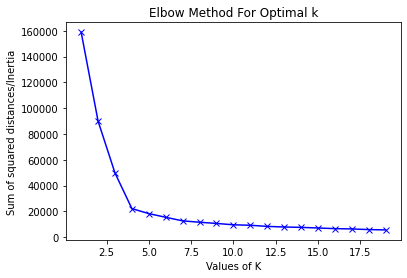

In [ ]:
elbow(tokenized_seqs)

In [ ]:
nclusters = 4
kmeans = KMeans(n_clusters=nclusters)
tarray = np.array(tokenized_seqs)
kmeans.fit(tarray)

KMeans(n_clusters=4)

In [ ]:
from sklearn.manifold import TSNE
def clusterData(data_array):
  color = kmeans.labels_
  #color = [np.argmax(i) for i in color] # take one-hot Convert encoding to integer 
  #color = np.stack(color, axis=0)
  group = color
  #cdict = {0:'black', 1: 'red', 2: 'blue', 3: 'green',}

  n_neighbors = 12   # How many categories are there 

  ##### 2D feature plot
  y = TSNE(n_components=2, learning_rate='auto',init='pca').fit_transform(data_array)
  scatter_x = y[:, 0]
  scatter_y = y[:, 1]

  #cdict = {0:'black', 1: 'red', 2: 'blue', 3: 'green', 4:'brown', 5:'gray', 6:'yellow', 7:'orange', 8:'purple', 9:'cyan', 10:'pink', 11:'olive',}
  fig = plt.figure(figsize=(8, 8))
  for g in np.unique(group):
      ix = np.where(group == g)
      plt.scatter(scatter_x[ix], scatter_y[ix] ,label = g, s = 10)
  plt.legend()
  plt.axis('off')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


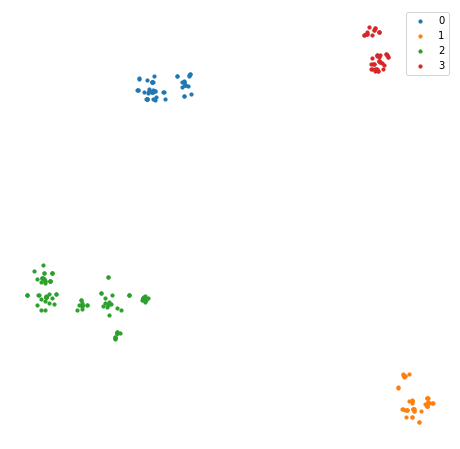

In [ ]:
clusterData(tarray)

#Compare the culster data with actual data

In [ ]:
# pred_array = kmeans.predict(tarray)
# print(pred_array)
# print(labels_all)
#print(label_to_count(pred_array))

In [ ]:
from sklearn.metrics import confusion_matrix
def confmtrx(labels,tarray):
  pred_array = kmeans.predict(tarray)
  cm = confusion_matrix(labels, pred_array)
  cm_df = pd.DataFrame(cm,
                      index = ["TERV","TARV", "THRV","TRV"], 
                      columns = ['0','1','2','3'])
  print("Actual lables")
  print(label_to_count(labels))
  print("predicted lables")
  print(label_to_count(pred_array))
  return cm_df



In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
# cm_df = pd.DataFrame(cm,
#                      index = ["TERV","TARV", "THRV","TRV"], 
#                      columns = ['0','1','2','3'])
# print("Actual lables")
# print(label_to_count(labels_all))
# print("predicted lables")
# print(label_to_count(pred_array))
# cm_df

In [ ]:
confusionMatrix = confmtrx(labels_all,tarray)
confusionMatrix

Actual lables
{1: 166, 3: 40, 2: 48, 0: 4}
predicted lables
{2: 105, 0: 55, 3: 47, 1: 51}


,0,1,2,3
TERV,1,2,1,0
TARV,25,39,69,33
THRV,19,3,21,5
TRV,10,7,14,9


##Save the clusterd data

In [ ]:
#Assign lables to clusters
pred_array = kmeans.predict(tarray)
seq_array = np.array(seqs_all)
data = {'seq':seq_array , 'type':pred_array }
df = pd.DataFrame(data)
os.chdir("/content/drive/MyDrive/clustering2/clusterd_data")
df.to_csv("C4_muB.csv")

In [ ]:
# add clusterType colomn to the dataframe
cluster = pred_array
os.chdir("/content/drive/MyDrive/clustering2/clustering")
DNAdf = pd.read_csv("muB.csv")
# replace type with revirous names
DNAdf['type'].replace([0,1,2,3],["TERV","TARV", "THRV","TRV"], inplace=True)
DNAdf['ClusterType'] = cluster
DNAdf.head(5)

,Unnamed: 0,sequence,type,ClusterType
0,0,ATGGGCAACGCAACGTCTGTCGTGCAAAACTTCAACATTCGAGGCG...,TARV,2
1,1,ATGGGCAACGCAACGTCTGTCGTGCAAAACTTCAACATTCGAGGCG...,TRV,2
2,2,ATGGGCAACGCAACGTCTGTCGTGCAAAACTTCAACATTCGAGGTG...,TARV,2
3,3,ATGGGCAACGCAACGTCTGTCGTGCAAAACTTCAACATTCGAGGCG...,TARV,2
4,4,ATGGGCAACGCAACGTCTGTCGTGCAAAACTTCAACATTCGAGGCG...,TARV,2


In [ ]:
#df = DNAdf.groupby(['ClusterType','type']).count()
#df
#DNAdf.loc[DNAdf['ClusterType'] == 0].groupby('type').count()['ClusterType']

# ndf = pd.DataFrame()
# ndf['type'] = DNAdf['type'].unique()
# for i in range(4):
#     ndf['Cluster' + str(i)] = DNAdf.loc[DNAdf['ClusterType'] == i].groupby('type').count()['ClusterType']
# #ndf

In [ ]:
df = DNAdf.groupby(['ClusterType','type']).count()
df

Unnamed: 0  sequence
ClusterType type                      
0           TARV          25        25
            TERV           1         1
            THRV          19        19
            TRV           10        10
1           TARV          39        39
            TERV           2         2
            THRV           3         3
            TRV            7         7
2           TARV          69        69
            TERV           1         1
            THRV          21        21
            TRV           14        14
3           TARV          33        33
            THRV           5         5
            TRV            9         9

In [ ]:
#df = pd.DataFrame({'ClusterType': ['0', '1','2', '3'],'TARV':[39,	69,	33,	25] , 'TERV': [2,	1, 0,	1],
#                   'THRV': [3,	21,	5,	19], 'TRV': [7,	14,	9,	10] })
                              
#df   
#ax = df.plot.bar(rot=0)
#ax = df.plot.bar(stacked=True)              

In [ ]:
# DNAdf.set_index('ClusterType', inplace=True)
# DNAdf.groupby('type').plot(kind='bar',legend=True)

#SigmaC Dataset 4 clusters

In [ ]:
os.chdir("/content/drive/MyDrive/clustering2/clustering")

In [ ]:
file_name = "sigmaC.csv"
seqs_all, labels_all = readData(file_name)
print(" seqs_all = "+str(len(seqs_all)), " labels_all = "+ str(len(labels_all)))

read line by line from file and store seq /  lables in lists 
 seqs_all = 256  labels_all = 256



 tokenized sequences 
 [[2. 3. 5. ... 2. 4. 4.]
 [2. 3. 5. ... 2. 4. 4.]
 [2. 3. 5. ... 2. 4. 4.]
 ...
 [2. 3. 5. ... 2. 4. 4.]
 [2. 3. 5. ... 2. 4. 4.]
 [2. 3. 5. ... 2. 4. 4.]] 

 letters to token {'<pad>': 0, '<unk>': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5, '-': 6} 

 label_to_count {1: 164, 3: 40, 2: 48, 0: 4}


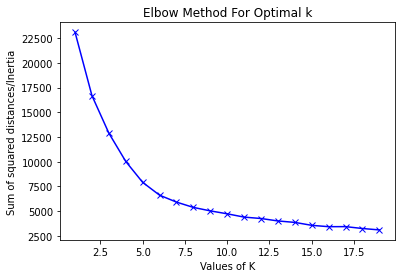

In [ ]:
#prepare dataset
tokenized_seqs = dataprep(seqs_all)
elbow(tokenized_seqs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


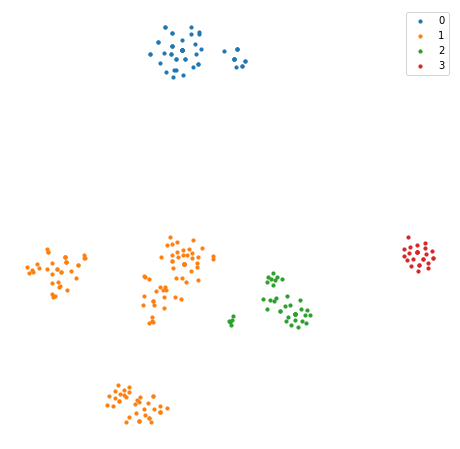

In [ ]:
nclusters = 4
kmeans = KMeans(n_clusters=nclusters)
tarray = np.array(tokenized_seqs)
kmeans.fit(tarray)
clusterData(tarray)

In [ ]:
from sklearn.metrics import confusion_matrix
def confmtrx(labels,tarray):
  pred_array = kmeans.predict(tarray)
  cm = confusion_matrix(labels, pred_array)
  cm_df = pd.DataFrame(cm,
                      index = ["TERV","TARV", "THRV","TRV"], 
                      columns = ['0','1','2','3'])
  print("Actual lables")
  print(label_to_count(labels))
  print("predicted lables")
  print(label_to_count(pred_array))
  return cm_df

In [ ]:
cmdf = confmtrx(labels_all,tarray)
cmdf

Actual lables
{1: 164, 3: 40, 2: 48, 0: 4}
predicted lables
{0: 57, 1: 133, 2: 40, 3: 26}


,0,1,2,3
TERV,0,1,3,0
TARV,37,73,37,17
THRV,15,32,0,1
TRV,5,27,0,8


In [ ]:
#Assign lables to clusters
pred_array = kmeans.predict(tarray)
seq_array = np.array(seqs_all)
data = {'seq':seq_array , 'type':pred_array }
df = pd.DataFrame(data)
os.chdir("/content/drive/MyDrive/clustering2/clusterd_data")
df.to_csv("C4_sigmaC.csv")

In [ ]:
# add clusterType colomn to the dataframe
cluster = pred_array
os.chdir("/content/drive/MyDrive/clustering2/clustering")
sCdf = pd.read_csv("sigmaC.csv")
sCdf['ClusterType'] = cluster
sCdf

,Unnamed: 0,sequence,type,ClusterType
0,0,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
1,1,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
2,2,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
3,3,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
4,4,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
...,...,...,...,...
251,251,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,2,0
252,252,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
253,253,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0
254,254,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,1,0


In [ ]:
df = sCdf.groupby(['ClusterType','type']).count()
df

Unnamed: 0  sequence
ClusterType type                      
0           1             37        37
            2             15        15
            3              5         5
1           0              1         1
            1             73        73
            2             32        32
            3             27        27
2           0              3         3
            1             37        37
3           1             17        17
            2              1         1
            3              8         8

# sigmaC with 5 clusters

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


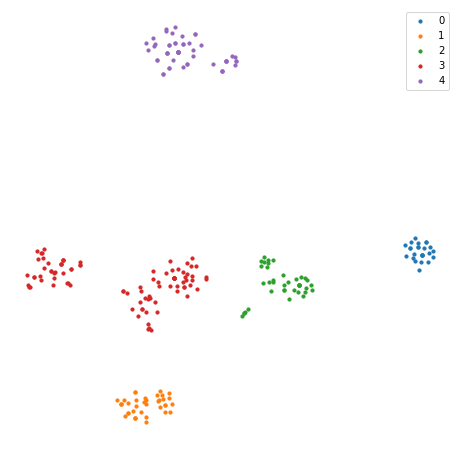

In [ ]:

nclusters = 5
kmeans = KMeans(n_clusters=nclusters)
tarray = np.array(tokenized_seqs)
kmeans.fit(tarray)
clusterData(tarray)

In [ ]:
#Assign lables to clusters
pred_array = kmeans.predict(tarray)
seq_array = np.array(seqs_all)
data = {'seq':seq_array , 'type':pred_array }
df = pd.DataFrame(data)
os.chdir("/content/drive/MyDrive/clustering2/clusterd_data")
df.to_csv("C5_sigmaC.csv")

In [ ]:
# add clusterType colomn to the dataframe
cluster = pred_array
os.chdir("/content/drive/MyDrive/clustering2/clustering")
sCdf = pd.read_csv("sigmaC.csv")
# replace type with revirous names
sCdf['type'].replace([0,1,2,3],["TERV","TARV", "THRV","TRV"], inplace=True)
sCdf['ClusterType'] = cluster
sCdf

,Unnamed: 0,sequence,type,ClusterType
0,0,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
1,1,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
2,2,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
3,3,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
4,4,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
...,...,...,...,...
251,251,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,THRV,4
252,252,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
253,253,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4
254,254,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,4


In [ ]:
df = sCdf.groupby(['ClusterType','type']).count()
df

Unnamed: 0  sequence
ClusterType type                      
0           TARV          17        17
            THRV           1         1
            TRV            8         8
1           TARV          23        23
            THRV           8         8
            TRV            7         7
2           TARV          37        37
            TERV           3         3
3           TARV          50        50
            TERV           1         1
            THRV          24        24
            TRV           20        20
4           TARV          37        37
            THRV          15        15
            TRV            5         5

#SigmaC dataset with 6 clusters

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


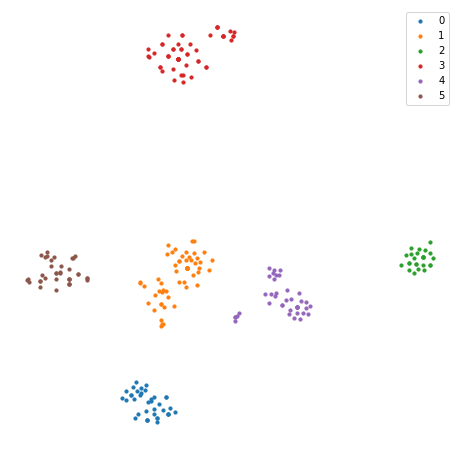

In [ ]:
nclusters = 6
kmeans = KMeans(n_clusters=nclusters)
tarray = np.array(tokenized_seqs)
kmeans.fit(tarray)
clusterData(tarray)

In [ ]:
#Assign lables to clusters
pred_array = kmeans.predict(tarray)
seq_array = np.array(seqs_all)
data = {'seq':seq_array , 'type':pred_array }
df = pd.DataFrame(data)
os.chdir("/content/drive/MyDrive/clustering2/clusterd_data")
df.to_csv("C6_sigmaC.csv")

In [ ]:
# add clusterType colomn to the dataframe
cluster = pred_array
os.chdir("/content/drive/MyDrive/clustering2/clustering")
sCdf = pd.read_csv("sigmaC.csv")
# replace type with revirous names
sCdf['type'].replace([0,1,2,3],["TERV","TARV", "THRV","TRV"], inplace=True)
sCdf['ClusterType'] = cluster
sCdf

,Unnamed: 0,sequence,type,ClusterType
0,0,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
1,1,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
2,2,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
3,3,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
4,4,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
...,...,...,...,...
251,251,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,THRV,3
252,252,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
253,253,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3
254,254,ATGGCCGCTCTAACTCCGTCACAGCGAAGAGAAGTCGTGGGATTGA...,TARV,3


In [ ]:
df = sCdf.groupby(['ClusterType','type']).count()
df

Unnamed: 0  sequence
ClusterType type                      
0           TARV          23        23
            THRV           8         8
            TRV            7         7
1           TARV          25        25
            TERV           1         1
            THRV          17        17
            TRV           15        15
2           TARV          17        17
            THRV           1         1
            TRV            8         8
3           TARV          37        37
            THRV          15        15
            TRV            5         5
4           TARV          37        37
            TERV           3         3
5           TARV          25        25
            THRV           7         7
            TRV            5         5